## This example from https://github.com/dask/dask-examples/blob/master/index.ipynb

This is a simple demonstration of image processing using dask arrays with [ghost cells](http://dask.pydata.org/en/latest/array-ghost.html).

We apply the Canny edge detection algorithm to our image. Which is suitable for ghosted arrays because it is relatively "local", that is each pixel depends on pixel only a small fixed distance away.

The algorithm applies a Gaussian filter to the image and then takes the 2D gradient. Points where the gradient is larger than some threshold are "edges".

So we create a dask array, then use it's `map_overlap` method to apply the edge detection function.

In [1]:
import numpy as np
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.io import imread

import dask.array as da
from dask.diagnostics import ProgressBar

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (15, 10)

In [2]:
! wget http://imgsrc.hubblesite.org/hu/db/images/hs-2004-07-a-full_jpg.jpg

--2016-10-28 11:30:32--  http://imgsrc.hubblesite.org/hu/db/images/hs-2004-07-a-full_jpg.jpg
Resolving imgsrc.hubblesite.org (imgsrc.hubblesite.org)... 96.126.121.185, 50.116.6.68, 23.92.31.164, ...
Connecting to imgsrc.hubblesite.org (imgsrc.hubblesite.org)|96.126.121.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63876090 (61M) [image/jpeg]
Saving to: ‘hs-2004-07-a-full_jpg.jpg.1’

hs-2004-07-a-full_j 100%[===================>]  60.92M  9.65MB/s    in 6.5s    

2016-10-28 11:30:39 (9.37 MB/s) - ‘hs-2004-07-a-full_jpg.jpg.1’ saved [63876090/63876090]



In [3]:
file_name = 'hs-2004-07-a-full_jpg.jpg' # hubble ultra deep field
color_img = imread(file_name) # ~ 61MB

In [4]:
color_img.shape, color_img.nbytes * 1e-6 # still in memory here

((6200, 6200, 3), 115.32)

In [5]:
# convert to greyscale
img = rgb2gray(color_img)  # this reshapes the array, so it is 2D now.
img.shape

(6200, 6200)

So we have the image in a numpy array. How does it look? We downsample this x100 so it does not crash the browser.

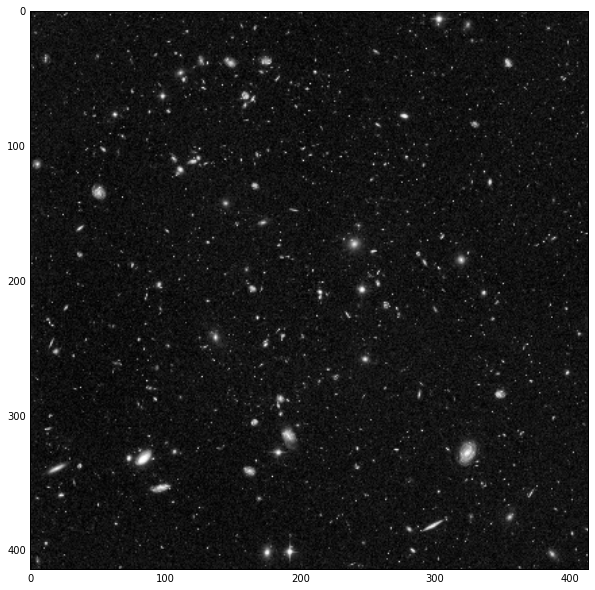

In [6]:
plt.imshow(img[::15, ::15], cmap='gray')

So lets create a dask array with this Numpy array.

In [7]:
arr = da.from_array(img, chunks=(1000, 1000))
arr.nbytes * 1e-6

307.52

In [8]:
arr

dask.array<array-1..., shape=(6200, 6200), dtype=float64, chunksize=(1000, 1000)>

We wrap the scikit image canny function so we can pass it to dask array.

In [23]:
def func(block):
    return canny(block, sigma=1.2)

Now we can add the padding. We choose 10 pixels. And the external boundary to be periodic.

In [24]:
padding = {0: 10, 1:10}
boundary = {0: 'periodic', 1:'periodic'}
canny_array = arr.map_overlap(func, depth=padding, boundary='periodic')

In [27]:
with ProgressBar():
    out = canny_array[4600:5400, 2400:3200].compute()

[########################################] | 100% Completed |  0.7s


We lets zoom in on an interesting section of this image. Loading the whole thing might crash the browser.

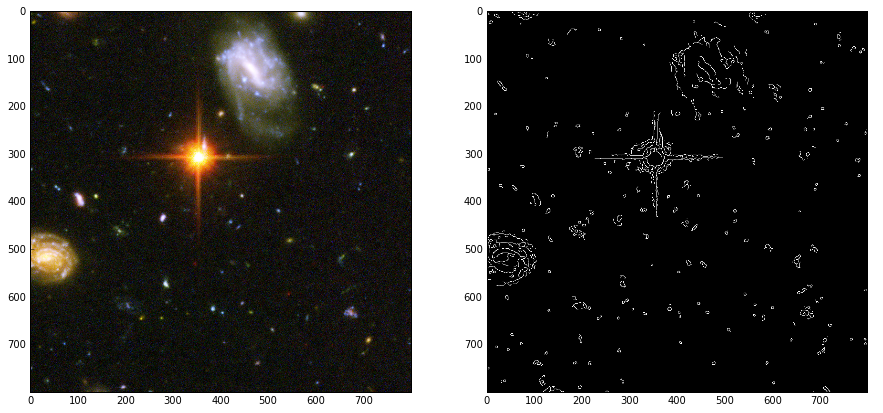

In [28]:
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(color_img[4600:5400, 2400:3200, :])
ax1.imshow(out, cmap='gray');

If you need to compute the edges of the entire image, then skimage provides the shorthand `apply_parallel` function:

In [21]:
from skimage import util

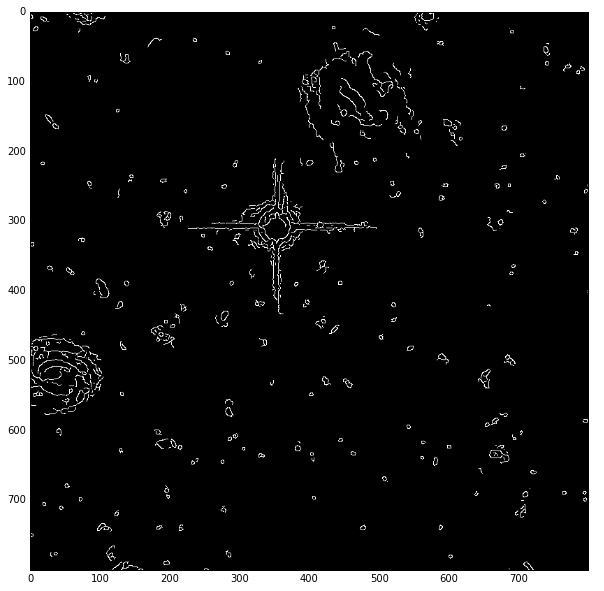

In [22]:
edges = util.apply_parallel(func, img)
plt.imshow(edges[4600:5400, 2400:3200], cmap='gray')